In [14]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, explode, when, lower, desc,count, mean, stddev, max, min, length
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import FuncFormatter

# Define the base GCS path 
gcs_folder = 'gs://msca-bdp-data-open/final_project_git'

**1. Cleaning and Saving DataFrames**

In [ ]:
# Clean and save commits data
commits_df = spark.read.parquet(f"{gcs_folder}/commits")

# Flatten nested fields
flattened_commits = commits_df.select(
    "commit",
    "tree",
    "parent",
    col("author.name").alias("author_name"),
    col("author.email").alias("author_email"),
    col("author.tz_offset").alias("author_tz_offset"),
    col("author.time_sec").alias("author_time_sec"),
    col("committer.name").alias("committer_name"),
    col("committer.email").alias("committer_email"),
    col("committer.tz_offset").alias("committer_tz_offset"),
    col("committer.time_sec").alias("committer_time_sec"),
    "repo_name",
    "subject",
    "message"
)

# Drop na values in useful columns
clean_commits = flattened_commits.dropna(subset=["commit", "repo_name", "author_time_sec", "committer_time_sec"])

#Remove duplicate commits
clean_commits = clean_commits.dropDuplicates(["commit"])

# Remove commits from bots
clean_commits = clean_commits.withColumn(
    "is_bot_author",
    when(lower(col("author_email")).rlike("bot|automation|noreply"), 1).otherwise(0)
).withColumn(
    "is_bot_committer",
    when(lower(col("committer_email")).rlike("bot|automation|noreply"), 1).otherwise(0)
).filter((col("is_bot_author") == 0) & (col("is_bot_committer") == 0))

24/12/05 20:30:27 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [5]:
# Clean and save languages data
languages_df = spark.read.parquet(f"{gcs_folder}/languages")

# Drop rows with missing values and ensure the 'language' field is not null
clean_languages = languages_df.dropna().filter(col("language").isNotNull())

# Flatten the nested 'language' field
flattened_languages = clean_languages.select(
    "repo_name",
    explode(col("language")).alias("language"),
    col("language.name").alias("language_name"),
    col("language.bytes").alias("language_bytes")
)

# Save the cleaned and flattened data to GCS
flattened_languages.write.mode("overwrite").parquet("gs://msca-bdp-students-bucket/shared_data/sjkim23/languages_data")

In [5]:
# Clean and save files data
files_df = spark.read.parquet(f"{gcs_folder}/files")
clean_files = files_df.dropna() \
    .filter(F.length("repo_name") > 0) \
    .filter(F.length("path") > 0) \
    .filter(F.col("mode").isNotNull())
clean_files.write.mode("overwrite").parquet("gs://msca-bdp-students-bucket/shared_data/sjkim23/files_data")

In [6]:
# Clean and save licenses data
licenses_df = spark.read.parquet(f"{gcs_folder}/licenses")
clean_licenses = licenses_df.dropna() \
    .filter(F.length("repo_name") > 0) \
    .filter(F.length("license") > 0)
clean_licenses.write.mode("overwrite").parquet("gs://msca-bdp-students-bucket/shared_data/sjkim23/licenses_data")

In [ ]:
# Clean and save contents data
contents_df = spark.read.parquet(f"{gcs_folder}/contents")
clean_contents = contents_df.dropna() \
    .filter(F.col("content").isNotNull()) \
    .filter(F.col("size") > 0)
clean_contents.write.mode("overwrite").parquet("gs://msca-bdp-students-bucket/shared_data/sjkim23/contents_data")

In [2]:
# Load necessary datasets for intermediate use
clean_files = spark.read.parquet("gs://msca-bdp-students-bucket/shared_data/sjkim23/files_data")
clean_licenses = spark.read.parquet("gs://msca-bdp-students-bucket/shared_data/sjkim23/licenses_data")

**2. Basic EDA**

In [18]:
# Print Schema
clean_commits.printSchema()
flattened_languages.printSchema()
clean_files.printSchema()
clean_licenses.printSchema()
clean_contents.printSchema()

root
 |-- commit: string (nullable = true)
 |-- tree: string (nullable = true)
 |-- parent: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- author_name: string (nullable = true)
 |-- author_email: string (nullable = true)
 |-- author_tz_offset: long (nullable = true)
 |-- author_time_sec: long (nullable = true)
 |-- committer_name: string (nullable = true)
 |-- committer_email: string (nullable = true)
 |-- committer_tz_offset: long (nullable = true)
 |-- committer_time_sec: long (nullable = true)
 |-- repo_name: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- subject: string (nullable = true)
 |-- message: string (nullable = true)

root
 |-- repo_name: string (nullable = true)
 |-- language: struct (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- bytes: long (nullable = true)
 |-- language_name: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- language_bytes: array (nullable = tru

In [ ]:
# Print record counts
print("\nCleaned Dataset Sizes:")
print(f"Commits: {clean_commits.count():,}")
print(f"Languages: {flattened_languages.count():,}")
print(f"Files: {clean_files.count():,}")
print(f"Licenses: {clean_licenses.count():,}")
print(f"Contents: {clean_contents.count():,}")


Cleaned Dataset Sizes:


Commits: 252,205,987


Languages: 7,839,289


Files: 5,224,300


Licenses: 3,325,634


Contents: 228,154,044


In [3]:
# Print original record counts
print("\nOriginal Dataset Sizes:")
print(f"Commits: {commits_df.count():,}")
print(f"Languages: {languages_df.count():,}")
print(f"Files: {files_df.count():,}")
print(f"Licenses: {licenses_df.count():,}")
print(f"Contents: {contents_df.count():,}")


Original Dataset Sizes:


Commits: 265,419,190
Languages: 3,325,634


Files: 2,309,424,945
Licenses: 3,325,634


Contents: 281,191,977


In [26]:
# Show first 3 rows of each dataset
clean_commits.show(3)
flattened_languages.show(3)
clean_files.show(3)
clean_licenses.show(3)
clean_contents.show(3)

+--------------------+--------------------+--------------------+-----------+--------------------+----------------+---------------+--------------+--------------------+-------------------+------------------+--------------------+--------------------+--------------------+-------------+----------------+
|              commit|                tree|              parent|author_name|        author_email|author_tz_offset|author_time_sec|committer_name|     committer_email|committer_tz_offset|committer_time_sec|           repo_name|             subject|             message|is_bot_author|is_bot_committer|
+--------------------+--------------------+--------------------+-----------+--------------------+----------------+---------------+--------------+--------------------+-------------------+------------------+--------------------+--------------------+--------------------+-------------+----------------+
|0000000f8a57a4557...|4d6a68b2e4b1f6763...|[00000007452182b5...| Teddy Katz|37c267b2cac445eb7...|   

+-----------------+---------+-------------+--------------+
|        repo_name| language|language_name|language_bytes|
+-----------------+---------+-------------+--------------+
|lemi136/puntovent|  {C, 80}|          [C]|          [80]|
|   taxigps/nctool|{C, 4461}|          [C]|        [4461]|
|      ahy1/strbuf|{C, 5573}|          [C]|        [5573]|
+-----------------+---------+-------------+--------------+
only showing top 3 rows



+-------------+-----------------+--------------------+-----+--------------------+--------------------+
|    repo_name|              ref|                path| mode|                  id|      symlink_target|
+-------------+-----------------+--------------------+-----+--------------------+--------------------+
|jonobr1/cdnjs|refs/heads/master|ajax/libs/raphael...|40960|59d781516a221df50...|      raphael.min.js|
|jonobr1/cdnjs|refs/heads/master|ajax/libs/vectori...|40960|fa4df87fa73a10c28...|       vectorious.js|
|jonobr1/cdnjs|refs/heads/master|ajax/libs/datatab...|40960|1584d2236b97ad50b...|../../2.1.5/swf/c...|
+-------------+-----------------+--------------------+-----+--------------------+--------------------+
only showing top 3 rows

+--------------------+------------+
|           repo_name|     license|
+--------------------+------------+
|autarch/Dist-Zill...|artistic-2.0|
|thundergnat/Prime...|artistic-2.0|
|kusha-b-k/Turabia...|artistic-2.0|
+--------------------+------------+
on

+--------------------+----+--------------------+------+------+
|                  id|size|             content|binary|copies|
+--------------------+----+--------------------+------+------+
|d5b1049fdaa182fa5...|1570|{"version":3,"sou...| false|   256|
|c62c391e494770dbd...| 256|# -*- encoding: u...| false|     1|
|a5f0a6fdebc99d68c...| 256|# Kconfig - ST ST...| false|     1|
+--------------------+----+--------------------+------+------+
only showing top 3 rows



In [55]:
# Load cleaned datasets for intermediate use
clean_commits = spark.read.parquet("gs://msca-bdp-students-bucket/shared_data/sjkim23/commits_data")
flattened_languages = spark.read.parquet("gs://msca-bdp-students-bucket/shared_data/sjkim23/languages_data")
clean_files = spark.read.parquet("gs://msca-bdp-students-bucket/shared_data/sjkim23/files_data")
clean_licenses = spark.read.parquet("gs://msca-bdp-students-bucket/shared_data/sjkim23/licenses_data")
clean_contents = spark.read.parquet("gs://msca-bdp-students-bucket/shared_data/sjkim23/contents_data")

In [28]:
# Commit analysis

#Find top authors and committers by name
clean_commits.groupBy("author_name").count().orderBy("count", ascending=False).show(10)
clean_commits.groupBy("committer_name").count().orderBy("count", ascending=False).show(10)

# Message analysis
print("\nCommit Message Analysis:")
clean_commits.select(
    F.length("message").alias("message_length")
).summary("count", "min", "25%", "75%", "max").show()

+--------------------+-------+
|         author_name|  count|
+--------------------+-------+
|          shenzhouzd|1188430|
|       Duane F. King| 597940|
|  Marge Spiderworthy| 495786|
|        Curt Clifton| 384915|
|James Michael DuPont| 343258|
|    CI Pool Resource| 316075|
|             unknown| 305814|
|                time| 286933|
|          miatribepi| 279802|
|             Jenkins| 279285|
+--------------------+-------+
only showing top 10 rows



+--------------------+--------+
|      committer_name|   count|
+--------------------+--------+
|              GitHub|16034303|
|       Duane F. King|  597940|
|  Gerrit Code Review|  596773|
|  Marge Spiderworthy|  495786|
|          Commit Bot|  417332|
|        Curt Clifton|  384915|
|James Michael DuPont|  343198|
|    CI Pool Resource|  316075|
|                root|  312552|
|             unknown|  306111|
+--------------------+--------+
only showing top 10 rows


Commit Message Analysis:


+-------+--------------+
|summary|message_length|
+-------+--------------+
|  count|     252205987|
|    min|             0|
|    25%|            22|
|    75%|            84|
|    max|      48222568|
+-------+--------------+



In [13]:
# Language analysis
# Explode `language_name` array for analysis
exploded_languages = flattened_languages.select(
    "repo_name",
    explode(col("language_name")).alias("exploded_language_name"),
    (col("language_bytes")).alias("exploded_language_bytes")
)

# Language Distribution
print("\nLanguage Distribution:")
exploded_languages.groupBy("exploded_language_name").count().orderBy(desc("count")).show(10)

# Explode `language_bytes` array for analysis
exploded_languages2 = exploded_languages.select(
    "repo_name",
    explode(col("exploded_language_bytes")).alias("exploded_language_bytes"),
    (col("exploded_language_name")).alias("exploded_language_name")
    
)

# Top Languages by Total Bytes
top_languages = exploded_languages2.groupBy("exploded_language_name").sum("exploded_language_bytes").orderBy(desc("sum(exploded_language_bytes)"))
top_languages.show(10, truncate=False)


Language Distribution:


+----------------------+-------+
|exploded_language_name|  count|
+----------------------+-------+
|            JavaScript|3941397|
|                   CSS|3452895|
|                  HTML|3355645|
|                 Shell|3155632|
|                Python|2238254|
|                     C|1804023|
|                   C++|1717426|
|              Makefile|1544946|
|                  Ruby|1348558|
|                   PHP|1300760|
+----------------------+-------+
only showing top 10 rows



+----------------------+----------------------------+
|exploded_language_name|sum(exploded_language_bytes)|
+----------------------+----------------------------+
|Shell                 |128749625052152             |
|Python                |117820947035887             |
|C                     |117617277220385             |
|C++                   |117578316874265             |
|Perl                  |113131246146718             |
|Objective-C           |112161857736462             |
|Assembly              |108287053597030             |
|Awk                   |92504782427689              |
|Scilab                |88101592062976              |
|Makefile              |81480796482832              |
+----------------------+----------------------------+
only showing top 10 rows



In [35]:
# File analysis

# Distribution of file modes
mode_distribution = clean_files.groupBy("mode").count().orderBy(desc("count"))
mode_distribution.show(10, truncate=False)

# Repositories with the most files
top_repos = clean_files.groupBy("repo_name").count().orderBy(desc("count"))
top_repos.show(10, truncate=False)

# Most common references
top_refs = clean_files.groupBy("ref").count().orderBy(desc("count"))
top_refs.show(10, truncate=False)

+-----+-------+
|mode |count  |
+-----+-------+
|40960|5224300|
+-----+-------+



+------------------------------------------------------------+------+
|repo_name                                                   |count |
+------------------------------------------------------------+------+
|daniruiz/Flat-Remix                                         |199905|
|Canar/meta                                                  |104475|
|PapirusDevelopmentTeam/papirus-icon-theme                   |57285 |
|mgor/dotfiles                                               |54480 |
|VirtualFlyBrain/VFB                                         |41006 |
|madmaxms/iconpack-obsidian                                  |40404 |
|phdenzel/dotfiles                                           |39503 |
|GreenRaccoon23/archdroid-icon-theme                         |39025 |
|h4ck3rm1k3/federal-election-commission-aggregation-json-2011|36716 |
|danielquinn/spirithunter                                    |35732 |
+------------------------------------------------------------+------+
only showing top 10 

+------------------------+-------+
|ref                     |count  |
+------------------------+-------+
|refs/heads/master       |4902385|
|refs/heads/devel        |39524  |
|refs/heads/develop      |36748  |
|refs/heads/sway         |31708  |
|refs/heads/main         |20471  |
|refs/heads/xfce         |18744  |
|refs/heads/gh-pages     |12399  |
|refs/heads/kernelsanders|8176   |
|refs/heads/development  |5080   |
|refs/heads/prod         |5027   |
+------------------------+-------+
only showing top 10 rows



In [7]:
# Analyze licenses 
repo_license_counts = clean_licenses.select("repo_name", "license")

# Get top licenses with counts and percentages
top_licenses = clean_licenses \
   .groupBy("license") \
   .count() \
   .withColumn(
       "percentage", 
       F.round(F.col("count") * 100 / clean_licenses.count(), 2)
   ) \
   .orderBy(F.desc("count"))

print("Most Popular Licenses:")
top_licenses.show(10, truncate=False)

# Get total unique licenses
unique_licenses = clean_licenses.select("license").distinct().count()
print(f"\nTotal unique licenses: {unique_licenses}")

Most Popular Licenses:


+------------+-------+----------+
|license     |count  |percentage|
+------------+-------+----------+
|mit         |1696489|51.01     |
|apache-2.0  |495134 |14.89     |
|gpl-2.0     |341505 |10.27     |
|gpl-3.0     |340407 |10.24     |
|bsd-3-clause|150701 |4.53      |
|bsd-2-clause|55221  |1.66      |
|unlicense   |46414  |1.4       |
|agpl-3.0    |41179  |1.24      |
|lgpl-3.0    |39839  |1.2       |
|cc0-1.0     |26807  |0.81      |
+------------+-------+----------+
only showing top 10 rows




Total unique licenses: 15


In [4]:
# Content analysis

# Analyze file size statistics
size_stats = clean_contents.select(
    count(col("size")).alias("total_files"),
    mean(col("size")).alias("avg_size"),
    stddev(col("size")).alias("stddev_size"),
    max(col("size")).alias("max_size"),
    min(col("size")).alias("min_size")
)
size_stats.show()

print("\nFile Size Distribution:")
clean_contents.select("size").summary("count", "min", "25%", "75%", "max").show()


# Analyze content lengths
content_stats = clean_contents.select(
    mean(length(col("content"))).alias("avg_content_length"),
    max(length(col("content"))).alias("max_content_length"),
    min(length(col("content"))).alias("min_content_length")
)
content_stats.show()

+-----------+------------------+------------------+--------+--------+
|total_files|          avg_size|       stddev_size|max_size|min_size|
+-----------+------------------+------------------+--------+--------+
|    2848271|11645.509775228551|49776.731979929245| 1048576|       1|
+-----------+------------------+------------------+--------+--------+


File Size Distribution:


+-------+-------+
|summary|   size|
+-------+-------+
|  count|2848271|
|    min|      1|
|    25%|    624|
|    75%|   6055|
|    max|1048576|
+-------+-------+



+------------------+------------------+------------------+
|avg_content_length|max_content_length|min_content_length|
+------------------+------------------+------------------+
|11432.898425746707|           1048576|                 1|
+------------------+------------------+------------------+



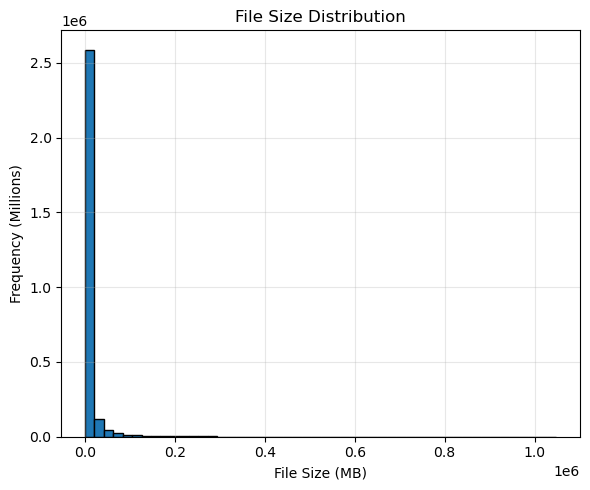

In [11]:
# Convert to Pandas
file_sizes = clean_contents.select("size").toPandas()
file_sizes["size_mb"] = file_sizes["size"] / (1024 * 1024)  # Convert bytes to MB

# Create the histogram
plt.figure(figsize=(6, 5))
plt.hist(file_sizes["size"], bins=50, edgecolor='black')
plt.title("File Size Distribution")
plt.xlabel("File Size (MB)")
plt.ylabel("Frequency (Millions)")

# Add grid for better readability
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
